In [ ]:
# Import the required libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import shap

sns.set(style="whitegrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
ds_file_path = '/content/drive/Dataset_Path/dataset_File.csv'
df = pd.read_csv(ds_file_path)



In [ ]:
# Fix potential column name issues
df.columns = df.columns.str.strip().str.lower()

# Drop non-predictive ID
df.drop(columns=["loan_id"], inplace=True)
df.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [ ]:
# Perform required data inspection and cleaning
df.info()
# Target distribution (imbalance check)
df['loan_status'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


,proportion
loan_status,
Approved,0.62216
Rejected,0.37784


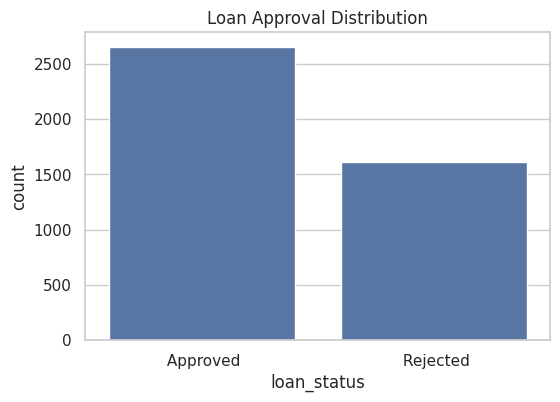

In [ ]:
# Visualise the data - Approved Lonas vs. Rejected Loans
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=df)
plt.title("Loan Approval Distribution")
plt.show()


In [ ]:
# Target Cleaning and Encoding
# Clean target values (remove spaces)
df["loan_status"] = df["loan_status"].str.strip()

# Encode target: Approved = 1, Rejected = 0
df["loan_status"] = df["loan_status"].map({
    "Approved": 1,
    "Rejected": 0
})

# Sanity check for encoded data
df["loan_status"].value_counts()

,count
loan_status,
1,2656
0,1613


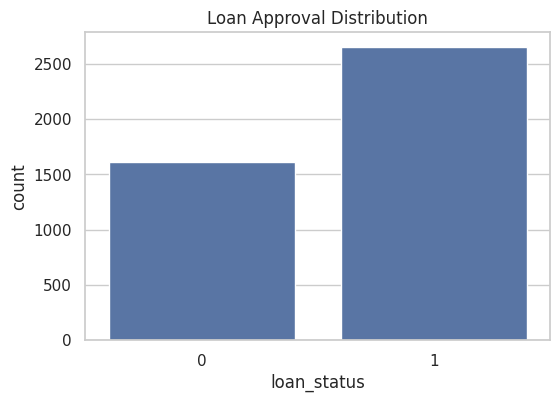

In [ ]:
# Data Visualisation after encoding
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=df)
plt.title("Loan Approval Distribution")
plt.show()

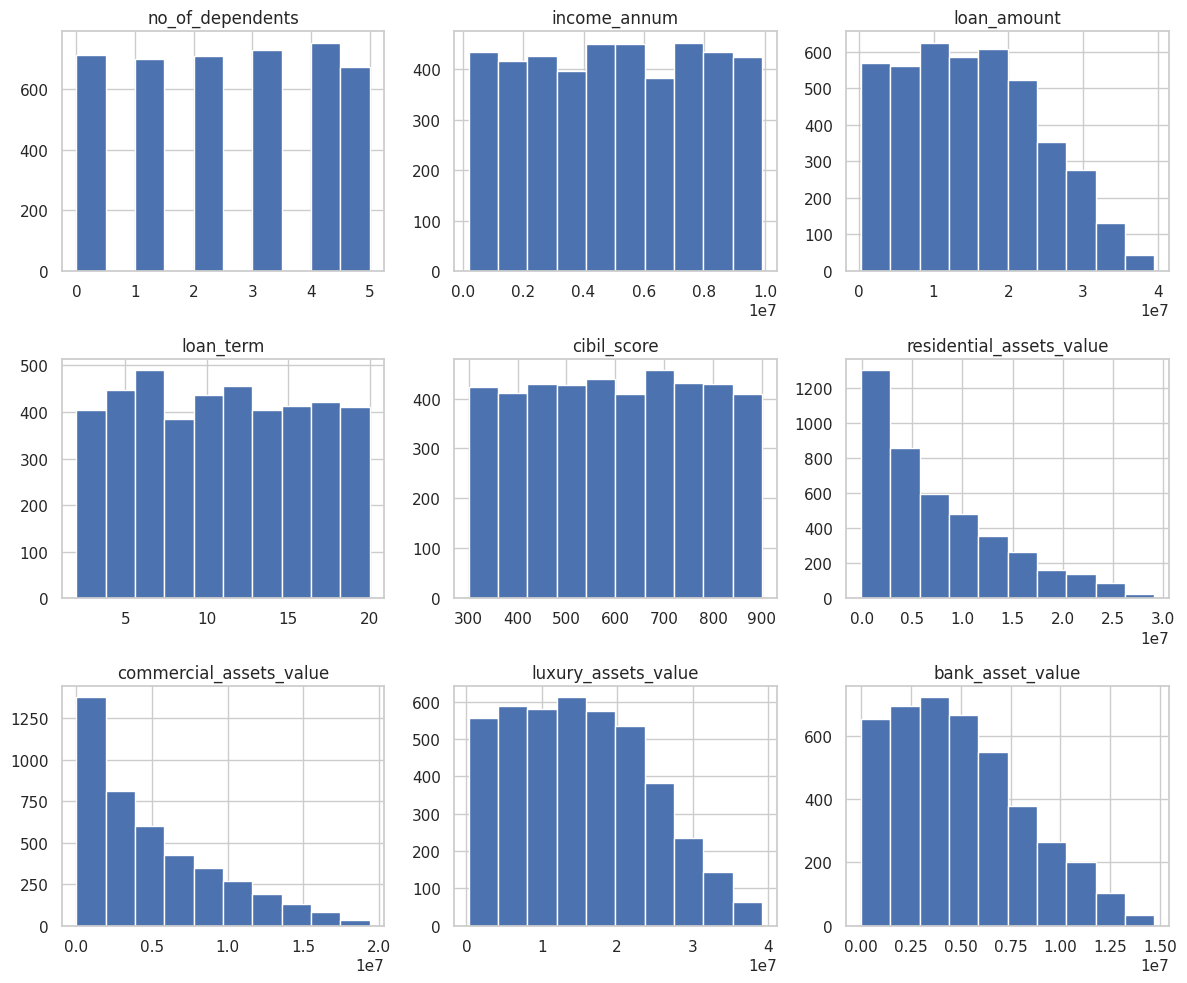

In [ ]:
# Numerical distributions across various features
df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

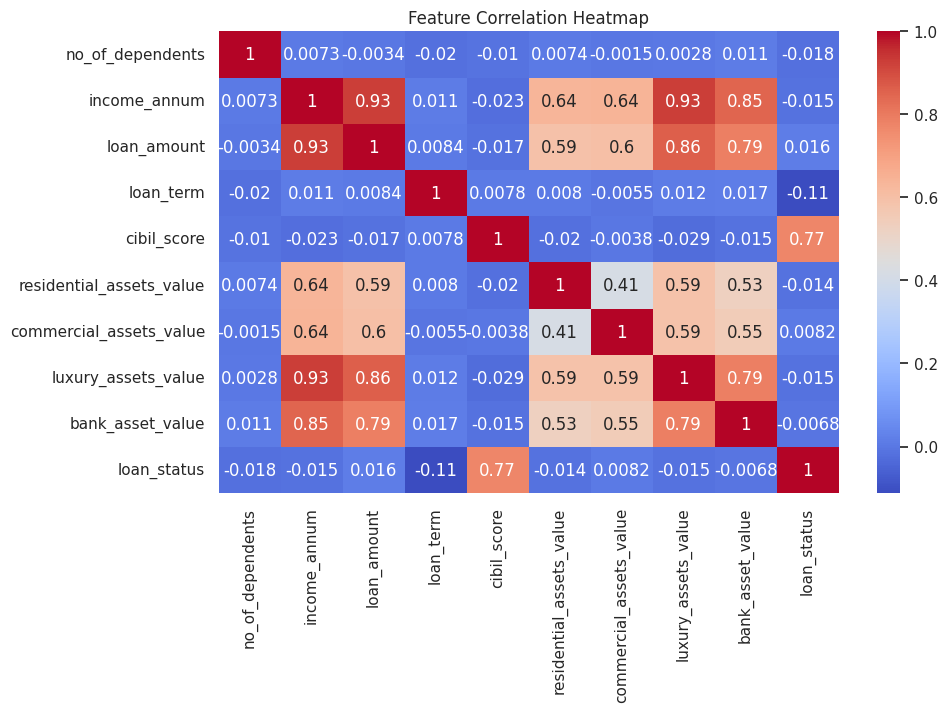

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

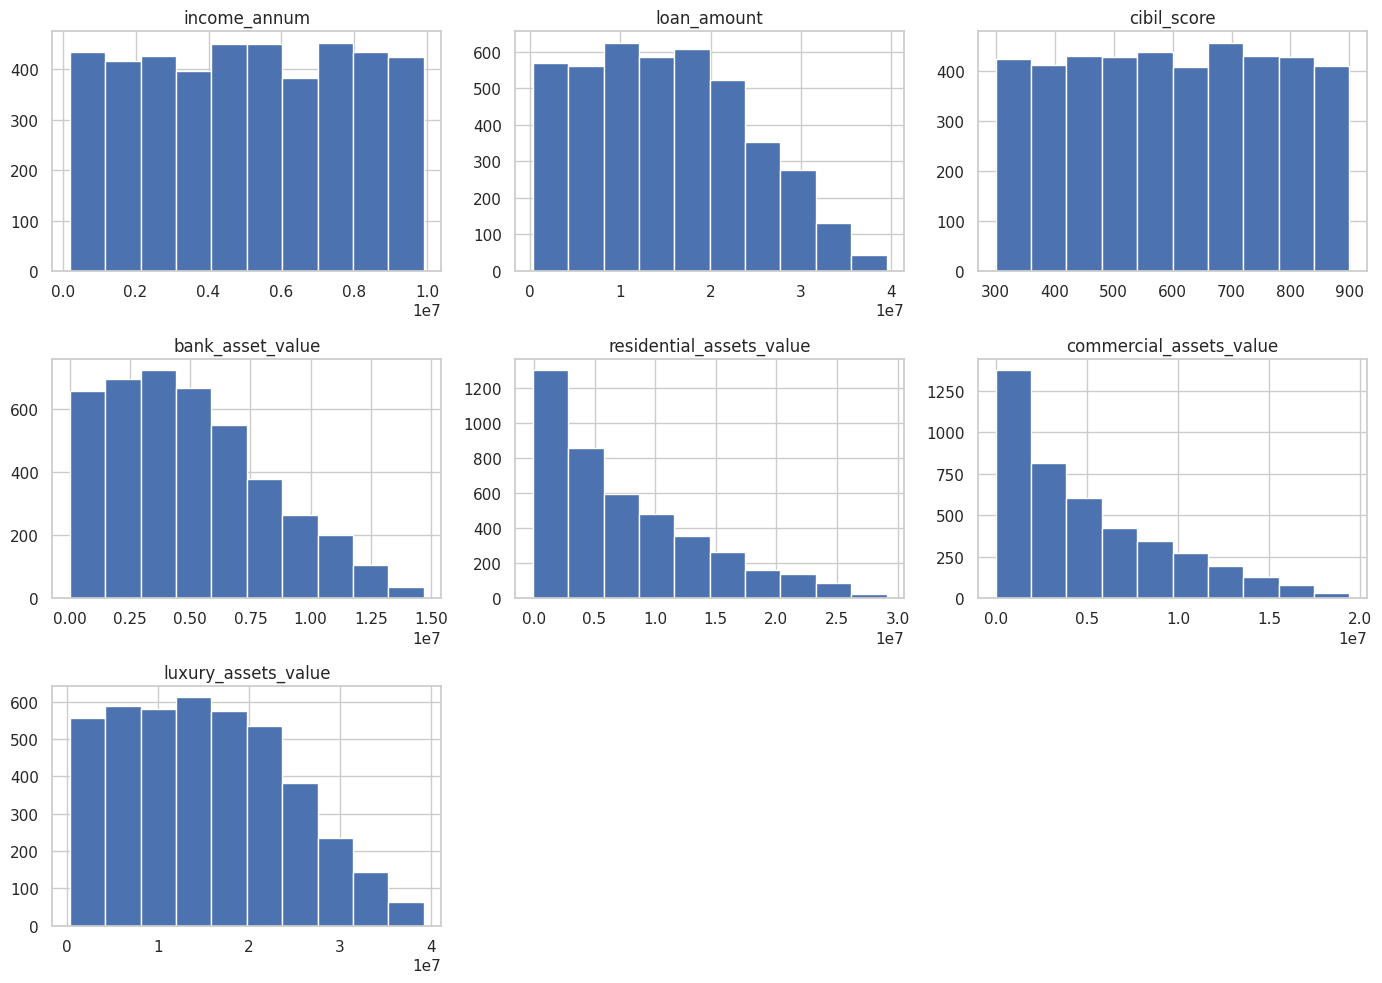

In [ ]:
# Futher EDA -Financial Risk Visualization
financial_features = [
    "income_annum", "loan_amount", "cibil_score",
    "bank_asset_value", "residential_assets_value",
    "commercial_assets_value", "luxury_assets_value"
]

df[financial_features].hist(figsize=(14,10))
plt.tight_layout()
plt.show()



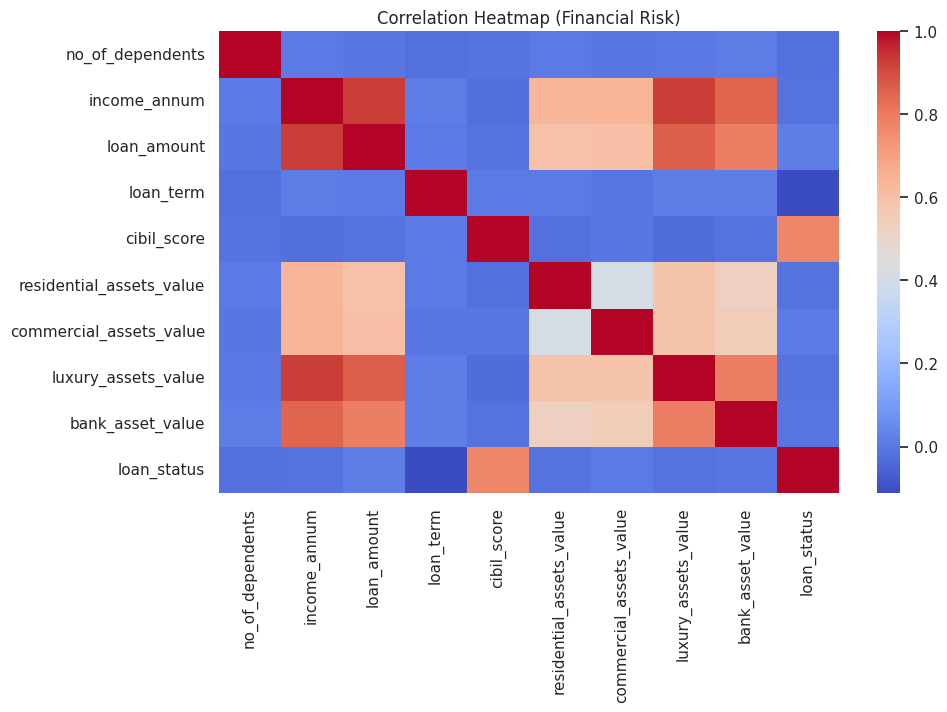

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap (Financial Risk)")
plt.show()

In [ ]:
# Feature and Target Separation
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

num_features = X.select_dtypes(include=np.number).columns
cat_features = X.select_dtypes(exclude=np.number).columns

In [ ]:
# Preprocessing Pipeline
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [ ]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=77
)

In [ ]:
# Logistic Regression (Imbalanced)
log_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(
        max_iter=1000,
        class_weight="balanced"
    ))
])

log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       404
           1       0.96      0.92      0.94       664

    accuracy                           0.92      1068
   macro avg       0.92      0.92      0.92      1068
weighted avg       0.93      0.92      0.92      1068



In [ ]:
# Random Forest (Imbalanced)
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        class_weight="balanced",
        random_state=77
    ))
])

rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       404
           1       0.98      0.99      0.98       664

    accuracy                           0.98      1068
   macro avg       0.98      0.98      0.98      1068
weighted avg       0.98      0.98      0.98      1068



In [ ]:
# Model Comparison (Before SMOTE) - LR vs. RF
results_before = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "Precision": [
        precision_score(y_test, y_pred_log),
        precision_score(y_test, y_pred_rf)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log),
        recall_score(y_test, y_pred_rf)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_log),
        f1_score(y_test, y_pred_rf)
    ]
})

results_before

,Model,Precision,Recall,F1-score
0,Logistic Regression,0.956113,0.918675,0.937020
1,Random Forest,0.977679,0.989458,0.983533


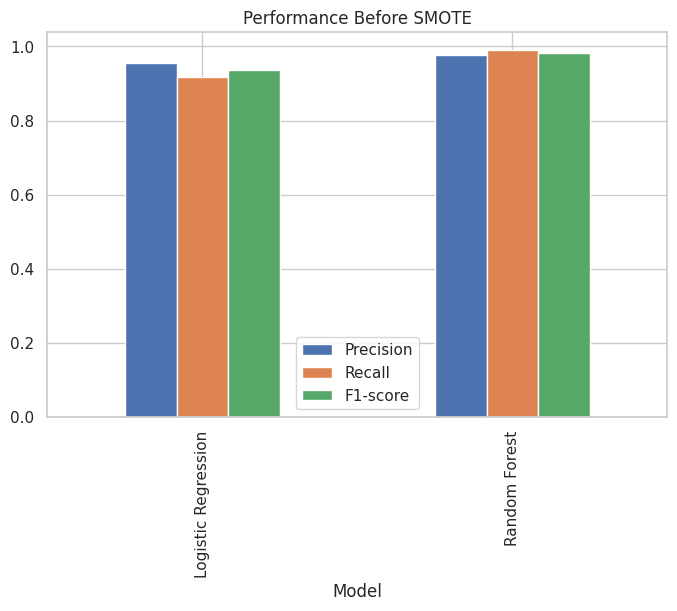

In [ ]:
results_before.set_index("Model").plot(kind="bar", figsize=(8,5))
plt.title("Performance Before SMOTE")
plt.show()

In [ ]:
# Logistic Regression + SMOTE
log_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=77)),
    ("classifier", LogisticRegression(max_iter=1000))
])

log_smote.fit(X_train, y_train)
y_pred_log_smote = log_smote.predict(X_test)

print(classification_report(y_test, y_pred_log_smote))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90       404
           1       0.96      0.92      0.94       664

    accuracy                           0.93      1068
   macro avg       0.92      0.93      0.92      1068
weighted avg       0.93      0.93      0.93      1068



In [ ]:
# Random Forest + SMOTE
rf_smote = ImbPipeline(steps=[
    ("preprocess", preprocessor),
    ("smote", SMOTE(random_state=77)),
    ("classifier", RandomForestClassifier(
        n_estimators=300,
        random_state=77
    ))
])

rf_smote.fit(X_train, y_train)
y_pred_rf_smote = rf_smote.predict(X_test)

print(classification_report(y_test, y_pred_rf_smote))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       404
           1       0.98      0.98      0.98       664

    accuracy                           0.98      1068
   macro avg       0.98      0.98      0.98      1068
weighted avg       0.98      0.98      0.98      1068



In [ ]:
# Comparison After SMOTE - LR vs. RF
results_after = pd.DataFrame({
    "Model": ["LogReg + SMOTE", "RF + SMOTE"],
    "Precision": [
        precision_score(y_test, y_pred_log_smote),
        precision_score(y_test, y_pred_rf_smote)
    ],
    "Recall": [
        recall_score(y_test, y_pred_log_smote),
        recall_score(y_test, y_pred_rf_smote)
    ],
    "F1-score": [
        f1_score(y_test, y_pred_log_smote),
        f1_score(y_test, y_pred_rf_smote)
    ]
})

results_after

,Model,Precision,Recall,F1-score
0,LogReg + SMOTE,0.956250,0.921687,0.938650
1,RF + SMOTE,0.983434,0.983434,0.983434


In [ ]:
# Feature Importance (Financial Risk)
# Extract trained RF model
rf_final = rf_smote.named_steps["classifier"]

feature_names = (
    num_features.tolist() +
    list(rf_smote.named_steps["preprocess"]
         .named_transformers_["cat"]
         .named_steps["encoder"]
         .get_feature_names_out(cat_features))
)

importances = rf_final.feature_importances_

fi = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

fi.head(15)

,Feature,Importance
4,cibil_score,0.809806
3,loan_term,0.059405
2,loan_amount,0.026000
1,income_annum,0.018031
7,luxury_assets_value,0.017393
5,residential_assets_value,0.016797
6,commercial_assets_value,0.015604
8,bank_asset_value,0.015008
0,no_of_dependents,0.013576
12,self_employed_ Yes,0.002341


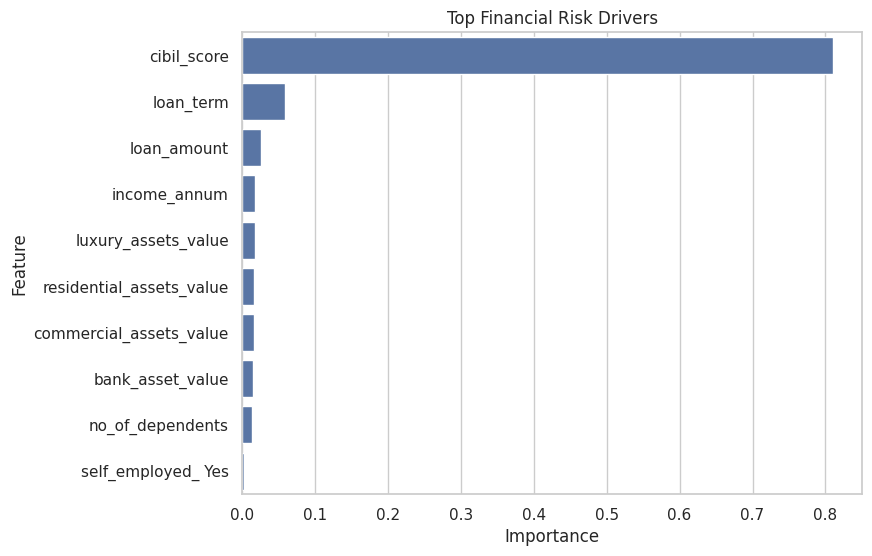

In [ ]:
# Visualisation of Top Financial Risk Drivers
plt.figure(figsize=(8,6))
sns.barplot(
    x="Importance",
    y="Feature",
    data=fi.head(10)
)
plt.title("Top Financial Risk Drivers")
plt.show()

In [ ]:
# SHAP Explainability (Random Forest)
# Preprocess test data
X_test_processed = rf_smote.named_steps["preprocess"].transform(X_test)

# Get trained RF model
rf_final = rf_smote.named_steps["classifier"]

# Use SHAP's unified explainer (handles shape issues better)
explainer = shap.Explainer(rf_final, X_test_processed)

shap_values = explainer(X_test_processed)

 99%|===================| 2118/2136 [01:10<00:00]       

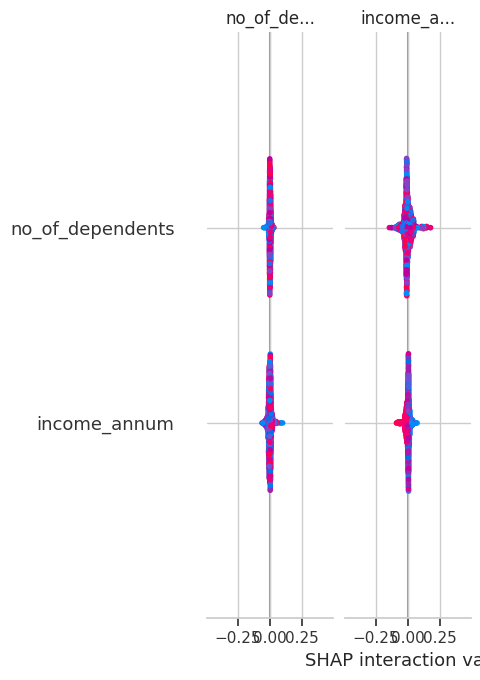

In [ ]:
# SHAP Plot
shap.summary_plot(
    shap_values.values,
    X_test_processed,
    feature_names=feature_names
)

**Notes about the SHAP summary plot**

The **SHAP (SHapley Additive exPlanations)** summary plot provides a global understanding of which features are most important for a model and how they impact the predictions. Here's a breakdown of how to interpret it:

**Y-axis:** Features (ordered by importance): The features are listed on the vertical axis, typically ordered from most important at the top to least important at the bottom. This order is determined by the average absolute SHAP value for each feature.

**X-axis:** SHAP Value: The horizontal axis represents the SHAP value for each feature. A positive SHAP value indicates that the feature pushes the prediction towards a higher (e.g., 'Approved' loan status in our case) outcome, while a negative SHAP value pushes the prediction towards a lower (e.g., 'Rejected' loan status) outcome.

**Color (Feature Value)**: The color of each dot on the plot indicates the original value of the feature for that specific data point. Typically, red indicates a high feature value, and blue indicates a low feature value. This allows you to see how different feature values influence the SHAP values.

**Position (Impact on Prediction)**: Each dot represents an individual data point. Its horizontal position shows the impact of that feature's value on the model's output (the SHAP value) for that particular prediction.

**Spread of the Dots**: The spread of the dots along the x-axis for each feature shows the distribution of SHAP values for that feature. A wider spread indicates that the feature has a more varied impact across different predictions.

In the context of the Loan Approval Predictor:

You'll likely see cibil_score at the top, indicating it's the most influential feature.
If a dot is red and to the right (positive SHAP value), it means a high cibil_score (high feature value) contributes to an 'Approved' loan.
If a dot is blue and to the left (negative SHAP value), it means a low cibil_score (low feature value) contributes to a 'Rejected' loan.
By examining the plot, you can understand not just which features are important, but how their values tend to affect the model's output for loan approval.